In [1]:
!pip install yfinance
!pip install pandas numpy matplotlib scikit-learn tensorflow

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     --- ----------------------

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
 
data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
 
data.head()


C:\Users\Inspiron 5584\AppData\Local\Temp\ipykernel_11472\2736800335.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,KO,KO,KO,KO,KO
Date,,,,,
2010-01-04,17.435402,17.490423,17.392608,17.472082,13870400
2010-01-05,17.224495,17.420125,17.160305,17.377330,23172400
2010-01-06,17.218384,17.252006,17.111399,17.224496,19264600
2010-01-07,17.175579,17.230600,17.041085,17.218374,13234600
2010-01-08,16.857681,17.007459,16.735413,16.952438,28712400


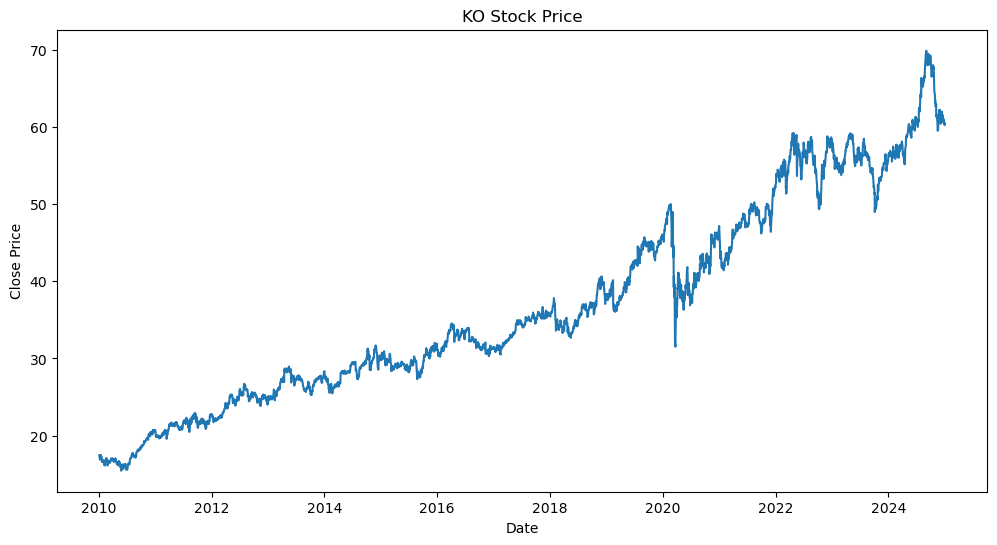

In [ ]:
data_close = data[['Close']] 
 
plt.figure(figsize=(12,6))
plt.plot(data_close)
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


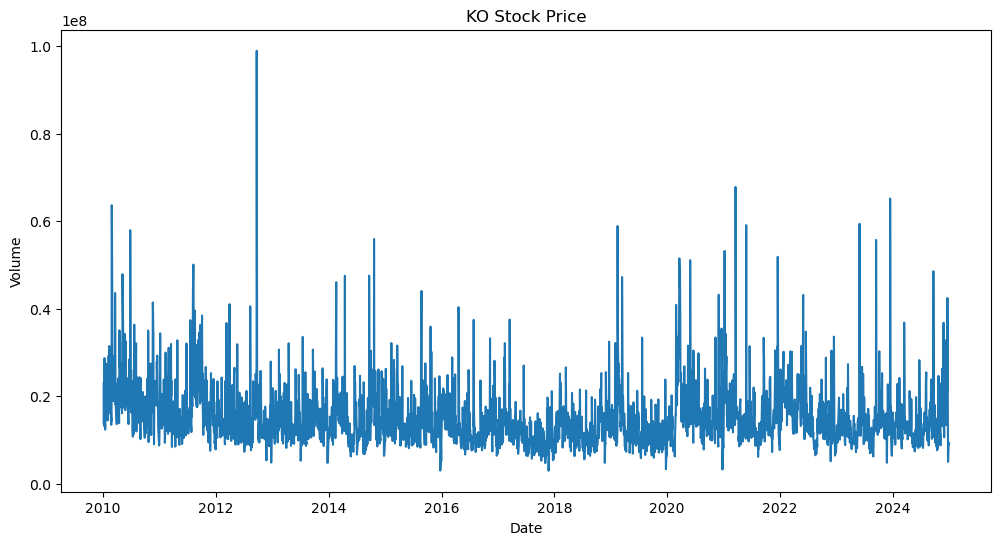

In [ ]:
data_volume = data[['Volume']]
 
plt.figure(figsize=(12,6))
plt.plot(data_volume)
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

In [17]:
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['Momentum'] = data['Close'] - data['Close'].shift(10)
data['Daily_Return'] = data['Close'].pct_change()
 
data = data.dropna()
data.head()

Price,Close,High,Low,Open,Volume,MA10,MA50,Momentum,Daily_Return
Ticker,KO,KO,KO,KO,KO,,,,
Date,,,,,,,,,
2010-03-16,16.548813,16.601201,16.508750,16.579630,22287800,16.567114,16.736297,0.256620,0.000932
2010-03-17,16.591946,16.638172,16.517984,16.585782,26074400,16.577832,16.719428,0.107183,0.002606
2010-03-18,16.625854,16.653590,16.561139,16.610446,23496200,16.575435,16.707455,-0.023970,0.002044
2010-03-19,16.872387,16.967921,16.517989,16.872387,43610800,16.590660,16.700535,0.152250,0.014828
2010-03-22,16.807674,16.903207,16.764531,16.792266,18127400,16.606750,16.693177,0.160902,-0.003835


In [18]:
features = data[['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']].values

sequence_lengths = [30, 60, 90]
lstm_units_list = [(50, 25), (100, 50)]
features_sets = [
    ['Close', 'Volume'],   
    ['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']   
]

In [20]:
train_size = int(len(features)*0.7)
val_size = int(len(features)*0.2)

train_data = features[:train_size]
val_data = features[train_size:train_size+val_size]
test_data = features[train_size+val_size:]
 
scaler = MinMaxScaler()
scaler.fit(train_data)  
 
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)
 


In [21]:
def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data_array)):
        X.append(data_array[i-seq_length:i])
        y.append(data_array[i, 0])   
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print(X_train.shape, y_train.shape)

(2547, 60, 6) (2547,)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))   

 
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit( X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val)) 

Epoch 1/50


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.0131 - val_loss: 0.0087
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0029 - val_loss: 0.0171
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0021 - val_loss: 0.0097
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0016 - val

In [23]:
pred_scaled = model.predict(X_test)
 
pred_full = np.zeros((pred_scaled.shape[0], features.shape[1]))
pred_full[:,0] = pred_scaled[:,0]   
pred_original = scaler.inverse_transform(pred_full)[:,0]
 
y_test_full = np.zeros((y_test.shape[0], features.shape[1]))
y_test_full[:,0] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:,0]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [24]:
mae = mean_absolute_error(y_test_original, pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, pred_original))
print("MAE:", mae, "RMSE:", rmse)

MAE: 0.8642351325312315 RMSE: 1.128809846715972


In [25]:
results = []
for features_list in features_sets:
    features = data[features_list].values
    
    for seq_length in sequence_lengths:
        
        def create_sequences(data_array, seq_length):
            X, y = [], []
            for i in range(seq_length, len(data_array)):
                X.append(data_array[i-seq_length:i])
                y.append(data_array[i,0])   
            return np.array(X), np.array(y)
         
        train_size = int(len(features)*0.7)
        val_size   = int(len(features)*0.2)
        train_data = features[:train_size]
        val_data   = features[train_size:train_size+val_size]
        test_data  = features[train_size+val_size:]

        scaler = MinMaxScaler()
        scaler.fit(train_data)
        train_scaled = scaler.transform(train_data)
        val_scaled   = scaler.transform(val_data)
        test_scaled  = scaler.transform(test_data)

        X_train, y_train = create_sequences(train_scaled, seq_length)
        X_val, y_val     = create_sequences(val_scaled, seq_length)
        X_test, y_test   = create_sequences(test_scaled, seq_length)

        for units in lstm_units_list: 
            model = Sequential()
            model.add(LSTM(units[0], return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
            model.add(Dropout(0.2))
            model.add(LSTM(units[1]))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.compile(optimizer=Adam(0.0005), loss='mean_squared_error')
 
            model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

           
            pred_scaled = model.predict(X_test)
            pred_full = np.zeros((pred_scaled.shape[0], features.shape[1]))
            pred_full[:,0] = pred_scaled[:,0]
            pred_original = scaler.inverse_transform(pred_full)[:,0]

            y_test_full = np.zeros((y_test.shape[0], features.shape[1]))
            y_test_full[:,0] = y_test
            y_test_original = scaler.inverse_transform(y_test_full)[:,0]

            
            rmse = np.sqrt(mean_squared_error(y_test_original, pred_original))
            print(f"Feature List:{features_list}  Sequence Length: {seq_length} LSTM Units: {units} -----> RMSE: {rmse}")
             
            results.append({
                'features': features_list,
                'seq_length': seq_length,
                'lstm_units': units,
                'rmse': rmse
            })
 
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rmse')
print(results_df)

d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Feature List:['Close', 'Volume']  Sequence Length: 30 LSTM Units: (50, 25) -----> RMSE: 3.0524114005775673


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Feature List:['Close', 'Volume']  Sequence Length: 30 LSTM Units: (100, 50) -----> RMSE: 1.3377029156133524


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Feature List:['Close', 'Volume']  Sequence Length: 60 LSTM Units: (50, 25) -----> RMSE: 3.9488446728442965


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Feature List:['Close', 'Volume']  Sequence Length: 60 LSTM Units: (100, 50) -----> RMSE: 1.2985834350189254


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Feature List:['Close', 'Volume']  Sequence Length: 90 LSTM Units: (50, 25) -----> RMSE: 2.9500027731193716


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Feature List:['Close', 'Volume']  Sequence Length: 90 LSTM Units: (100, 50) -----> RMSE: 1.4415532792666823


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 30 LSTM Units: (50, 25) -----> RMSE: 3.7581506280129346


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 30 LSTM Units: (100, 50) -----> RMSE: 1.4515110862075202


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 60 LSTM Units: (50, 25) -----> RMSE: 2.5950426803033126


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 60 LSTM Units: (100, 50) -----> RMSE: 2.785731874605802


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 90 LSTM Units: (50, 25) -----> RMSE: 5.719377824592601


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Feature List:['Close', 'Volume', 'MA10', 'MA50', 'Momentum', 'Daily_Return']  Sequence Length: 90 LSTM Units: (100, 50) -----> RMSE: 2.016238690159978
                                             features  seq_length lstm_units  \
3                                     [Close, Volume]          60  (100, 50)   
1                                     [Close, Volume]          30  (100, 50)   
5                                     [Close, Volume]          90  (100, 50)   
7   [Close, Volume, MA10, MA50, Momentum, Daily_Re...          30  (100, 50)   
11  [Close, Volume, MA10, MA50, Momentum, Daily_Re...          90  (100, 50)   
8   [Close, Volume, MA10, MA50, Momentum, Daily_Re...          60   (50, 25)   
9   [Close, Volume, MA10, MA50, Momentum, Daily_Re...          60  (100, 50)   
4                                     [Close, Volume]          90   (50, 25)   
0                                     [Close, Volume]          30   (50, 25)   
6   [Close

In [26]:
tickers = ['AAPL', 'KO', 'PG']        
features_list = ['Close', 'Volume']   
sequence_lengths = [30, 60]           
lstm_units_list = [(50,25),(100,50)]   
epochs = 20
batch_size = 32
 
all_results = []

def add_derived_features(df):
    df['MA10'] = df['Close'].rolling(10).mean()
    df['MA50'] = df['Close'].rolling(50).mean()
    df['Momentum'] = df['Close'] - df['Close'].shift(10)
    df['Daily_Return'] = df['Close'].pct_change()
    df = df.dropna()
    return df

def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data_array)):
        X.append(data_array[i-seq_length:i])
        y.append(data_array[i, 0])  
    return np.array(X), np.array(y)

for ticker in tickers:
    
    df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
    df = add_derived_features(df)
    
    for seq_length in sequence_lengths:
        features = df[features_list].values
        
        train_size = int(len(features)*0.7)
        val_size   = int(len(features)*0.2)
        train_data = features[:train_size]
        val_data   = features[train_size:train_size+val_size]
        test_data  = features[train_size+val_size:]
        
        scaler = MinMaxScaler()
        scaler.fit(train_data)
        train_scaled = scaler.transform(train_data)
        val_scaled   = scaler.transform(val_data)
        test_scaled  = scaler.transform(test_data)
        
        X_train, y_train = create_sequences(train_scaled, seq_length)
        X_val, y_val     = create_sequences(val_scaled, seq_length)
        X_test, y_test   = create_sequences(test_scaled, seq_length)
        
        for units in lstm_units_list:
            model = Sequential()
            model.add(LSTM(units[0], return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
            model.add(Dropout(0.2))
            model.add(LSTM(units[1]))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.compile(optimizer=Adam(0.0005), loss='mean_squared_error')
            
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val), verbose=0)
            
            pred_scaled = model.predict(X_test)
            pred_full = np.zeros((pred_scaled.shape[0], features.shape[1]))
            pred_full[:,0] = pred_scaled[:,0]
            pred_original = scaler.inverse_transform(pred_full)[:,0]
            
            y_test_full = np.zeros((y_test.shape[0], features.shape[1]))
            y_test_full[:,0] = y_test
            y_test_original = scaler.inverse_transform(y_test_full)[:,0]
            
            rmse = np.sqrt(mean_squared_error(y_test_original, pred_original))
            mae  = mean_absolute_error(y_test_original, pred_original)
            
            all_results.append({
                'Ticker': ticker,
                'Seq_Length': seq_length,
                'LSTM_Units': units,
                'RMSE': rmse,
                'MAE': mae
            })
            
            print(f"Ticker:{ticker} Seq:{seq_length} Units:{units} --> RMSE:{rmse:.2f} MAE:{mae:.2f}")

results_df = pd.DataFrame(all_results)
print("\n===== SUMMARY =====")
print(results_df.sort_values(by='RMSE'))


C:\Users\Inspiron 5584\AppData\Local\Temp\ipykernel_11472\4154449422.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Ticker:AAPL Seq:30 Units:(50, 25) --> RMSE:31.76 MAE:29.81


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Ticker:AAPL Seq:30 Units:(100, 50) --> RMSE:9.47 MAE:8.10


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Ticker:AAPL Seq:60 Units:(50, 25) --> RMSE:38.98 MAE:36.76


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Ticker:AAPL Seq:60 Units:(100, 50) --> RMSE:9.98 MAE:7.87


C:\Users\Inspiron 5584\AppData\Local\Temp\ipykernel_11472\4154449422.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Ticker:KO Seq:30 Units:(50, 25) --> RMSE:3.98 MAE:3.61


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Ticker:KO Seq:30 Units:(100, 50) --> RMSE:1.17 MAE:0.94


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Ticker:KO Seq:60 Units:(50, 25) --> RMSE:2.93 MAE:2.61


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Ticker:KO Seq:60 Units:(100, 50) --> RMSE:1.36 MAE:1.09


C:\Users\Inspiron 5584\AppData\Local\Temp\ipykernel_11472\4154449422.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Ticker:PG Seq:30 Units:(50, 25) --> RMSE:16.83 MAE:16.14


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Ticker:PG Seq:30 Units:(100, 50) --> RMSE:14.79 MAE:14.31


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Ticker:PG Seq:60 Units:(50, 25) --> RMSE:12.06 MAE:11.33


d:\Mas\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Ticker:PG Seq:60 Units:(100, 50) --> RMSE:12.67 MAE:12.10

===== SUMMARY =====
   Ticker  Seq_Length LSTM_Units       RMSE        MAE
5      KO          30  (100, 50)   1.173918   0.936552
7      KO          60  (100, 50)   1.359753   1.089778
6      KO          60   (50, 25)   2.928200   2.613694
4      KO          30   (50, 25)   3.976358   3.611454
1    AAPL          30  (100, 50)   9.472338   8.099733
3    AAPL          60  (100, 50)   9.978914   7.867785
10     PG          60   (50, 25)  12.062277  11.331618
11     PG          60  (100, 50)  12.667101  12.099174
9      PG          30  (100, 50)  14.790761  14.310739
8      PG          30   (50, 25)  16.827920  16.139423
0    AAPL          30   (50, 25)  31.762674  29.805707
2    AAPL          60   (50, 25)  38.983133  36.755970
